# Final Analyis and Model Development

1. Add Dwarka and Central Delhi (Done)
9. No. of bathrooms in listing html
10. Direction which it faces in html (could be imp - requires digging into the html again.)
11. Deposit in html
12. Furnishing Status in html (could be imp)

## To DO: 
1. Plot the listings on a map. (Done)
2. See if adding/augmenting with more data helps. (Doing, sort of helping.)
3. Add closest metro station Distance.(Done, The variability of results is down)
4. Add closest large hospital Distance. (Skipped for now)
5. Create New Notebook And Do Analyis and Final Model Fitting.(Log transformation and feature scaling done.)
6. Create clean pipeline for final Model.
6. Create a simple functions for prediction or webpage with inputs, problem with one-hot encoded input to model. 160 different values for locality, from dropdown, pick one then function creates input acc. to index.

In [244]:
# Get the Scraped data and Engineer features, data type transformation etc. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, SCORERS, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
sns.set_palette('husl')

### Strategy to Deal with outliers
Removed extreme outliers when it comes to rental price and size. 

In [1406]:
rent_data= pd.read_csv('Data/Rent_data_makaan_june_13_metro_closest_stations.csv', index_col=0)

In [1408]:
# Removing Extreme outliers (Central Delhi listings in multiple tens of lakhs. Extremely Large houses, listings 
# in the extreme outskirts of Delhi)
rent_data = rent_data[rent_data.price < 510000]
rent_data = rent_data[rent_data.size_sq_ft < 16000]
rent_data = rent_data[rent_data.closest_mtero_station_km < 11]
rent_data.reset_index(drop=True, inplace=True)

All Data Wrangling/Feature Engineering in seperate notebook called 'Wrangling'.<br>
12099 Listings in Dataset.

## Univariate Analysis -  Quantitative Variables
Looking at distributions of the quantitaive columns, investigating interesting columns later.

1. Size in Square Feet - The distribution of size of houses has a mean around 1100 sq.feet and is heavily positively skewed, long tail of larger houses.
2. Bedrooms is a discrete variable and we can infer that the most common arrangement is a 2 bedroom house.
3. The latitude and longitude appear to be multimodal as the dataset contains listings from 5 different regions of the city, and the dataset doesn't appear to have an imbalance of houses from a single region of the city(more on that later). The co-ordinates have been used to calculate distances from important landmarks and the metro stations.
4. Price(Monthly Rent) is the target variable and has a similar distribution to size with most listings around the 20,000 range. Again highly skewed, Log transformed later.
5. Closest Metro Station - most listings are closer to metro stations, similar distribution to price and size. The outliers are places like bawana etc in the North. This is geodisc distance, so not as useful as road distance which can be found using the GMaps API but is a paid feature. https://developers.google.com/maps/documentation/distance-matrix/usage-and-billing
6. Airport, AIIMS, NDLS Raileay Station distance from listings is also visualised, could be important considerations for listings but can also lead to collinearity (checked later).

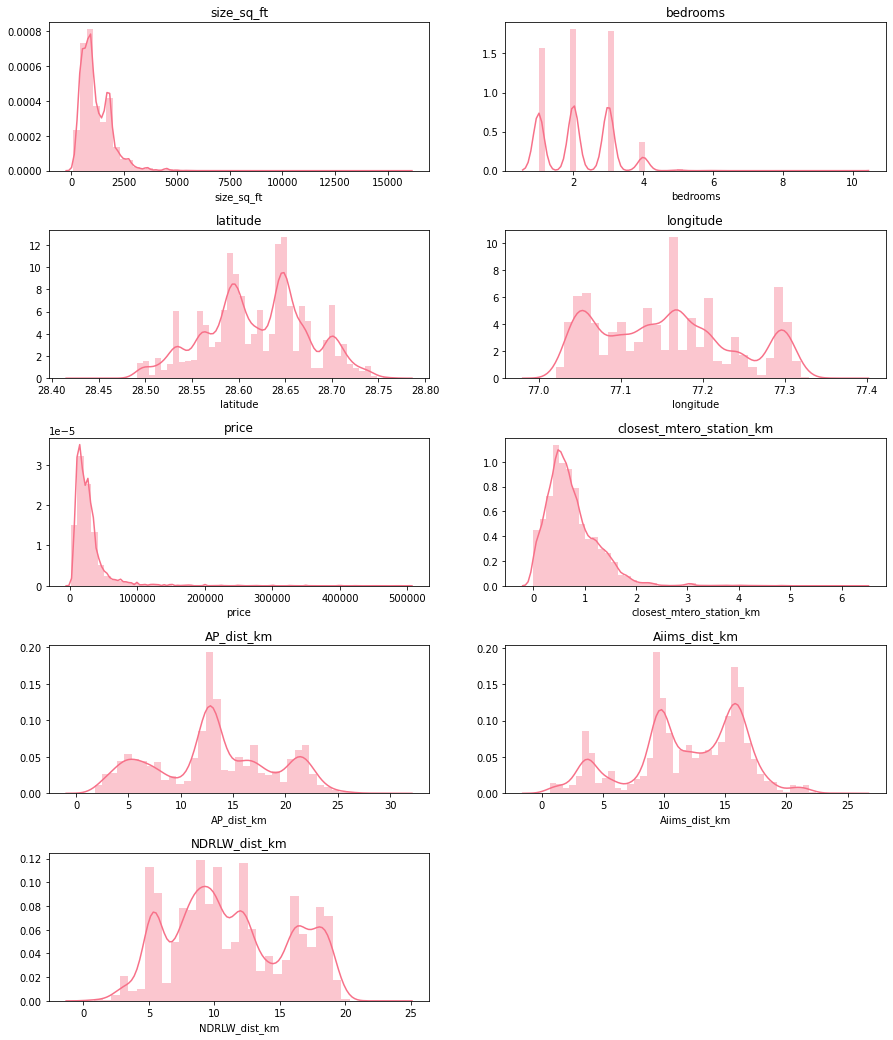

In [896]:
fig = plt.figure(figsize=(15,18))
for i,item in enumerate(rent_data.select_dtypes([np.number]).columns):
    ax = fig.add_subplot(5, 2, i+1)
    fig.subplots_adjust(hspace=0.4)
    sns.distplot(rent_data[item])
    ax.set_title(item)

### Boxplot to check for outliers
Again, size, price and closest metro stations are heavily skewed columns.Can benifit from a log transformation.

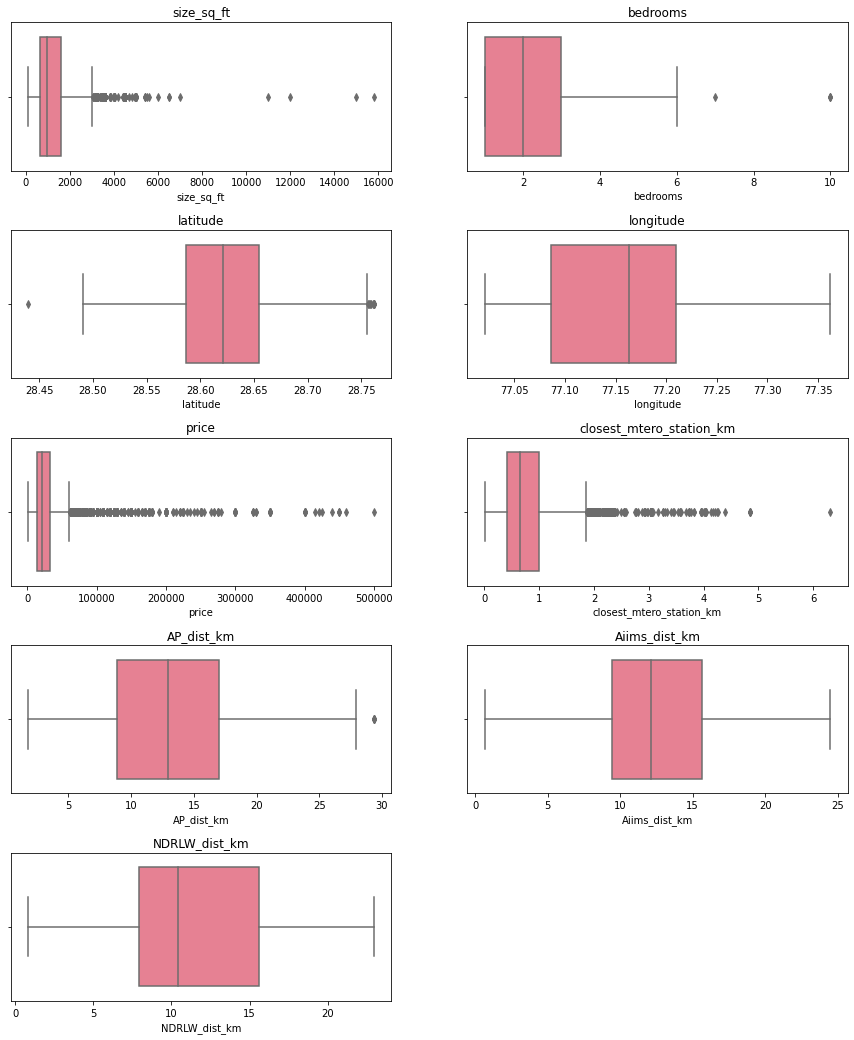

In [897]:
fig = plt.figure(figsize=(15,18))
for i,item in enumerate(rent_data.select_dtypes([np.number]).columns):
    ax = fig.add_subplot(5, 2, i+1)
    fig.subplots_adjust(hspace=0.4)
    sns.boxplot(rent_data[item])
    ax.set_title(item)

#### Closer look at target - Price (monthly rent)
Very Heavily skewed with a median at Rs.20K and 75% of the listings below Rs.40K.(Outliers in target is a big problem). 
<br>Although the tree based regression methods used later are robust to outliers and don't require the target to be normal, log transforming the target gives it a normal-ish distribution and results in .2-.3 increase in R<sup>2</sup> Score.

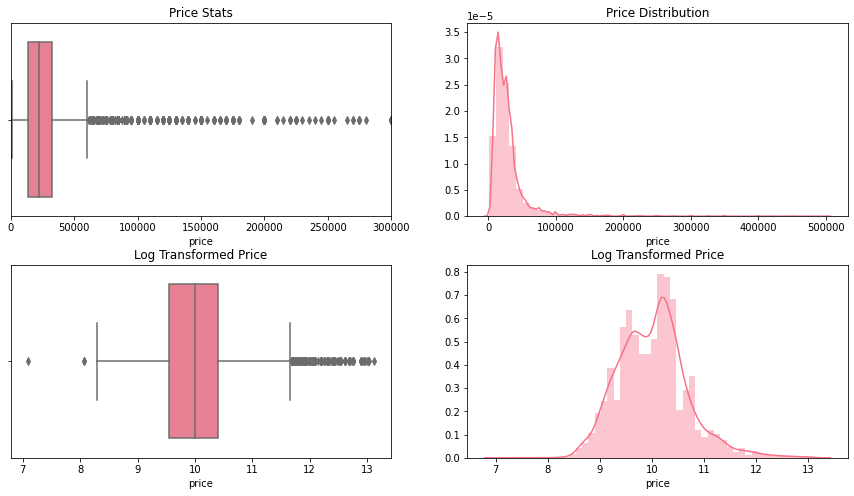

In [898]:
fig, axes = plt.subplots(2,2, figsize = (15,8))
fig.subplots_adjust(hspace=0.25)
axes[0][0].set_xlim(0, 300000)
axes[0][0].set_title('Price Stats')
sns.boxplot(rent_data.price, ax = axes[0][0])
axes[0][1].set_title('Price Distribution')
sns.distplot(rent_data.price, ax = axes[0][1])
axes[1][0].set_title('Log Transformed Price')
sns.boxplot(np.log(rent_data.price), ax = axes[1][0])
axes[1][1].set_title('Log Transformed Price')
sns.distplot(np.log(rent_data.price), ax = axes[1][1])
plt.show()

## Univariate Analysis - Categorical Variables

1. Just a simple self explanatory value counts of the data displaying the most dominant class in the categorical data. 
2. Most listings are for Independednt floors, and the division of listings is pretty equal between the different regions of the city if we include Rohini in the northern part of the city. Care was taken to make sure equal proportion in both train and validation set when modeling.
3. 2BHK is the most common arrangement but this differs by region as analysed later. 
4. The most prevalent dealers are a good predictor but have been left out keeping production considerations in mind, users are not expected to have dealer preferences/constraints in mind. Also had high cardinality (~500 values, encoded down to 133 by grouping all dealers with less than 10 listings as independent.) 
5. The cityName column was dropped and PropertyType, suburbname were one hot encoded as is. 
6. Locality name had high cardinality (160) but proved to be a good predictor and was one-hot encoded as is without modification.
7. The bedrooms predictor had high collinearity with size in sq.feet and was dropped with minimal penalty in accuracy and improved cross-validation R<sup>2</sup> std. dev.

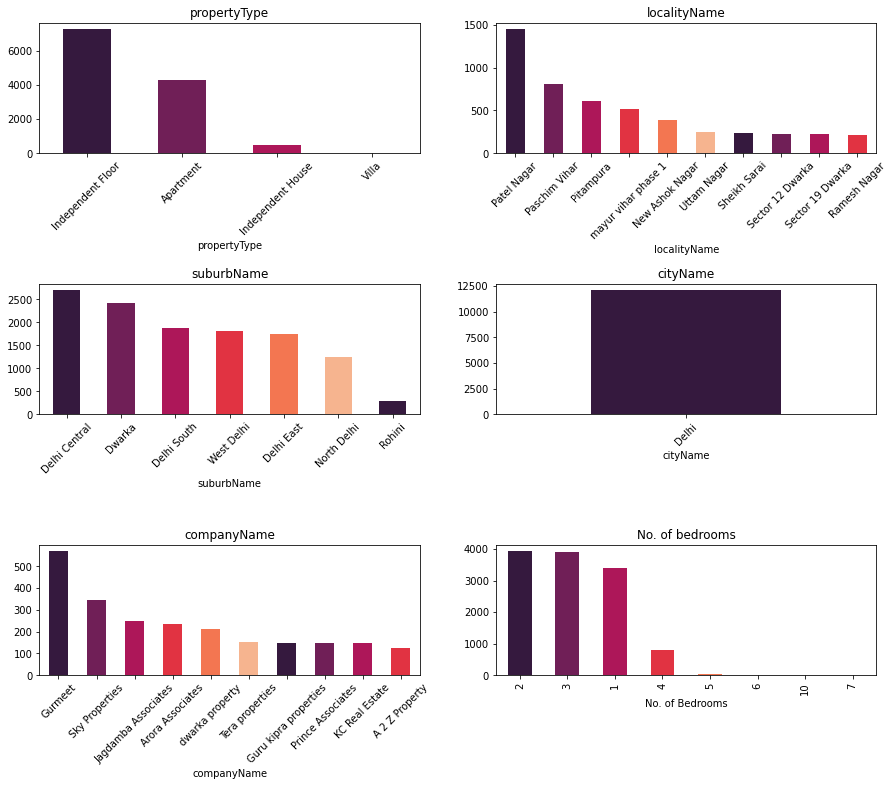

In [899]:
fig = plt.figure(figsize=(15,12))
for i,item in enumerate(rent_data.select_dtypes('object').columns):
    ax = fig.add_subplot(3, 2, i+1)
    fig.subplots_adjust(hspace=1)
    rent_data[item].value_counts()[:10].plot(kind = 'bar', rot = 45,
                                             color = sns.color_palette('rocket')).set(xlabel=item)
    ax.set_title(item)

ax = fig.add_subplot(3, 2, 6)
ax.set_title('No. of bedrooms')
rent_data.bedrooms.value_counts().plot(kind = 'bar',color = sns.color_palette('rocket')).set(xlabel='No. of Bedrooms')
plt.show()

## Multivariate Analysis and Data Interaction
1. Looking at the geographical distribution of listings, they are reasonably distributed between the regions of Delhi.
2. Looking at the distributions of price and size, there semms to be high correlation between them(confirmed later using a coreelation matrix) and is an important predictor.
3. ALso evident is the distinction of areas where smaller and more affordable houses (East Delhi) are located and areas with a large right tail (South Delhi) which are posh areas. 
4. Most Listings are close to metro stations. Could be an interesting predictor.

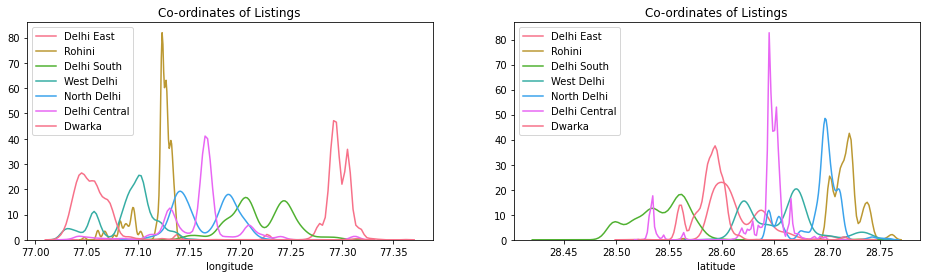

In [900]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.longitude.loc[rent_data.suburbName == item],label = item, ax = axes[0]
                 , hist = False).set(title = 'Co-ordinates of Listings')
    axes[0].legend()
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.latitude.loc[rent_data.suburbName == item],label = item, ax = axes[1]
                 , hist = False).set(title = 'Co-ordinates of Listings')
    axes[1].legend()
plt.show()

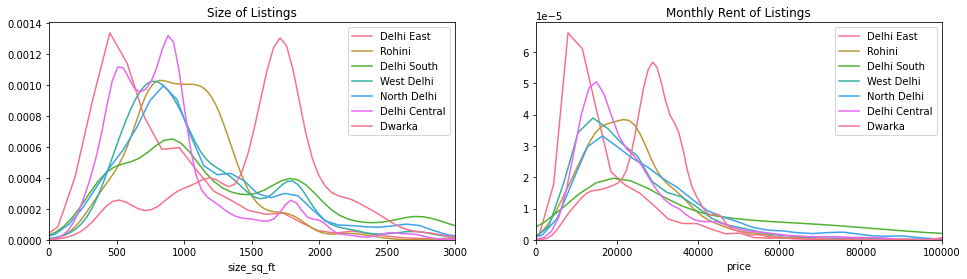

In [901]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.size_sq_ft.loc[rent_data.suburbName == item],label = item
                 , ax = axes[0], hist = False).set(title = 'Size of Listings')
    axes[0].set_xlim(0,3000)
    axes[0].legend()
for item in rent_data.suburbName.unique():
    sns.distplot((rent_data.price.loc[rent_data.suburbName == item]),label = item, ax = axes[1],
                 hist = False).set(title = 'Monthly Rent of Listings')
    axes[1].set_xlim(0,100000)
    axes[1].legend()
plt.show()

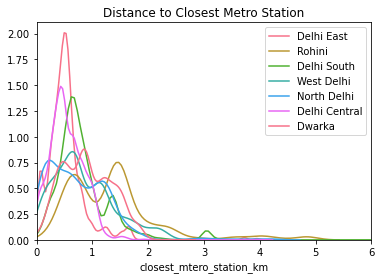

In [902]:
plt.xlim(0,6)
for item in rent_data.suburbName.unique():
    sns.distplot(rent_data.closest_mtero_station_km.loc[rent_data.suburbName == item],
                 label = item, hist = False).set(title = 'Distance to Closest Metro Station')
plt.legend()
plt.show()

#### Price and Size of listings by Regions
1. Unsurprisingly the most expensive and larger listings are from South Delhi.
2. Most regions have a large number of outliers that can prove problematic when modeling.

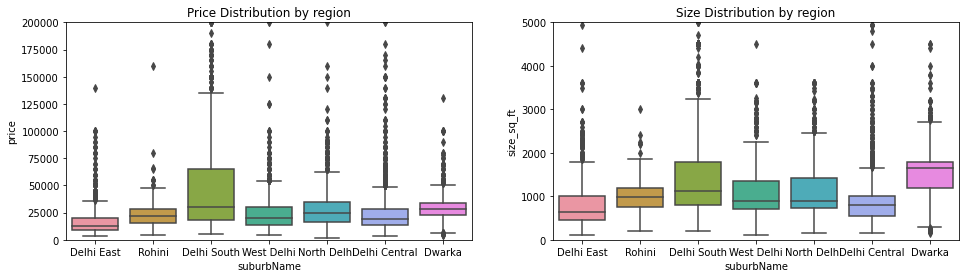

In [903]:
fig, axes = plt.subplots(1,2, figsize = (16,4))
sns.boxplot(x = 'suburbName', y = 'price',
            data = rent_data, ax = axes[0]).set(title = 'Price Distribution by region')
axes[0].set_ylim(0, 200000)
sns.boxplot(x = 'suburbName', y = 'size_sq_ft'
            , data = rent_data, ax = axes[1]).set(title = 'Size Distribution by region')
axes[1].set_ylim(0, 5000)
plt.show()

#### Division of Property Type and no. of bedrooms by Region.
1. Again, the majority of houses in South Delhi are 3+ bedrooms. 
2. In the other regions the typical listing is of smaller hosues. 
3. Most listings are of independent floors, Dwarka is mostly listings of apartments.

In [904]:
# pivot table to get in format suitable for stacked bargraphs
bed_sub = rent_data.pivot_table(columns='bedrooms', index='suburbName',
                      aggfunc='count').iloc[:,:6]
prop_sub = rent_data.pivot_table(columns='propertyType', index='suburbName',
                      aggfunc='count').iloc[:,:4]

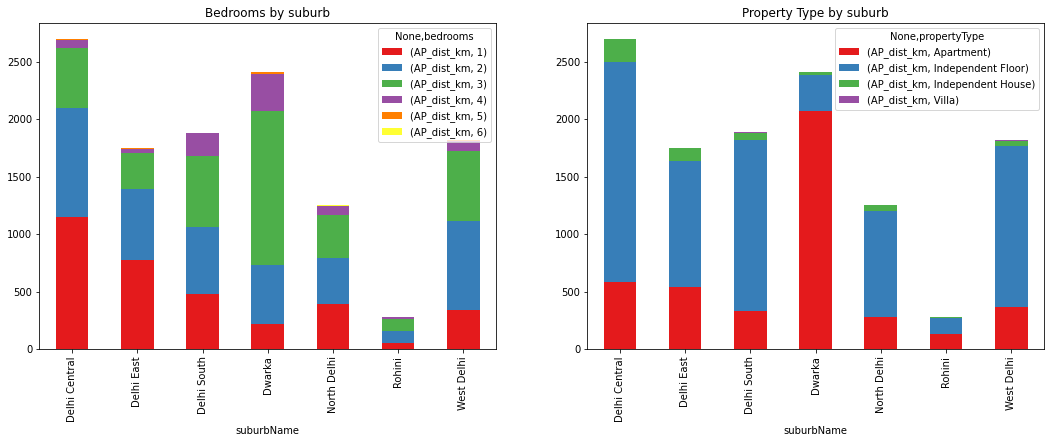

In [905]:
fig, axes = plt.subplots(1,2, figsize = (18,6))
bed_sub.plot(kind = 'bar',stacked = True,color =sns.color_palette('Set1'), ax = axes[0], title = 'Bedrooms by suburb')
prop_sub.plot(kind = 'bar',stacked = True, color =sns.color_palette('Set1'), ax = axes[1], title = 'Property Type by suburb')
plt.show()

## Correlation Analysis - Checking Persons correlation for continuous variables.
<b>Collinearity is when the predictors are correlated</b>
1. In the regression context, collinearity between predictors (> .7 Pearsons R) results in less stable and interpretable results, most ML algorithms can deal with collinear predictors when it comes to predictive modelling, but dropiing the collinear columns resulted in less standard deviation in the cross validated R<sup>2</sup> score and lower MAE, MSE.
2. Dropped bedrooms(correlated with size), co-ordinates(correlated with landmarks)

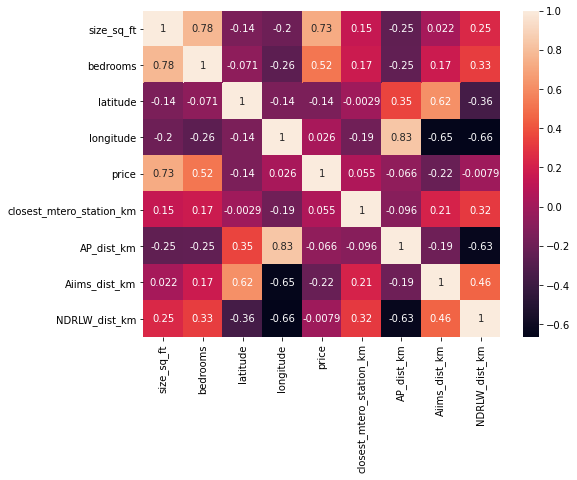

In [906]:
plt.figure(figsize = (8,6))
sns.heatmap(rent_data.corr(method='pearson'), annot=True)
plt.show()

In [907]:
# Most correlated features - After Dropping co-ordinates, Keeping bedrooms for now, just for visualisations.
temp_corr = rent_data.corr()
corr_list = []
pair_feat = []
for i, item in enumerate(list(combinations(temp_corr.drop(['latitude', 'longitude'], axis =1).columns.to_list(),2))):
    pair_feat.append(item)
    
for item in pair_feat:
    corr_list.append([item[0], item[1], np.abs(temp_corr.at[item[0], item[1]])])

corr_array = np.array(corr_list)
corr_array = corr_array[corr_array[:,2].argsort()][::-1]

### Data Interaction of correlated features
1. Strong positive Linear relationship between size of house and monthly rent. The relationship appear to be non linear for listings in south Delhi (Blue), clearly other variables at play. 
2. Expected positive relation between bedrooms and size. 
3. Bedrooms and price has a similar positive linear relationship as with size. 
4. The price and distance from Airport, AIIMs plot (7, 10) show that their isn't a strong negative relationship between the two, might not be that effective for predictions.
5. The rest of the correlated predictors are just the distance between landmarks and don't have predictive value.

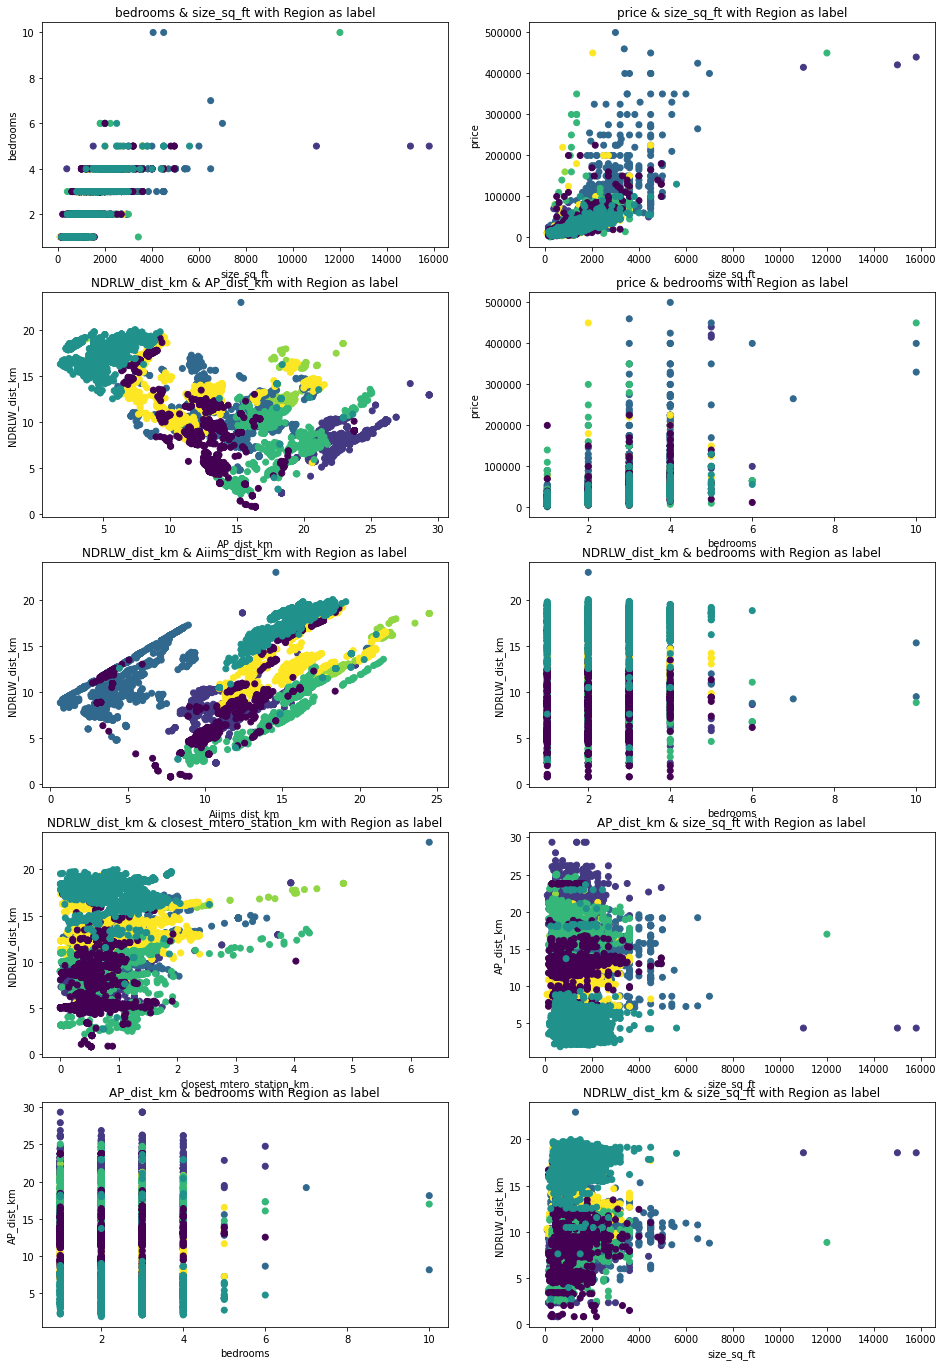

In [908]:
fig = plt.figure(figsize = (16,24))
for i, item in enumerate(corr_array[:10]):
    ax = fig.add_subplot(5, 2, i+1)
    plt.scatter(x = rent_data[item[0]].values, y = rent_data[item[1]].values,
                c = LabelEncoder().fit_transform(rent_data.suburbName.values))
    ax.set_title(item[1] + ' & ' + item[0] + ' with Region as label') 
    ax.set_xlabel(item[0])
    ax.set_ylabel(item[1])    
plt.show()

#### Difference between size and price relationship acrosss regions
Shows that listings in south Delhi command a premium over ones in North Delhi, followed closely by the other regions.

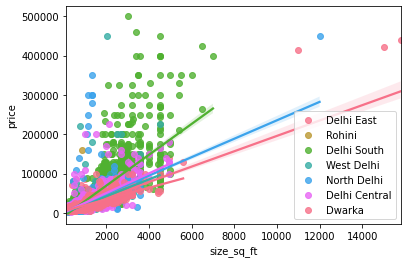

In [909]:
for item in rent_data.suburbName.unique():
    sns.regplot( x= 'size_sq_ft', y = 'price', data = rent_data.loc[rent_data['suburbName'] == item],
                label = item, robust = True)
    plt.legend()

### Visualising Rent Market Trends
Embedded figure, created using Gmaps API and coordinates of listings. heat map layer that will tell us where the highest rents of the city are. <br>
1. Most high value properties are clustered in South Delhi, Patel Nagar, Paschim Vihar, Dwarka. THe variety in listings (Apartments, floors, houses) and extreme outliers makes it difficult to compare at this scale but general trends are visible.<br>
The max intensity is rent of Rs.2 lakh/mo.
![](Static/complete_heatmap_2lac.png)

### Data Transformations 

In [910]:
# Optional, if using company name as feature.
rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() > 10]
redundant = rent_data.companyName.value_counts().loc[rent_data.companyName.value_counts() < 10].index.to_list()
for item in redundant:
    rent_data.loc[(rent_data.companyName == item),['companyName']] = 'Independent'

In [174]:
# Optional, doesn't help that much.
log_price = np.log(rent_data.price)
rent_data['price'] = log_price

# Modelling - Using Tree based Regresion Methods
Tree based Regression methods offer great performance, are robust to outliers, scale invariant and Boosted trees often beat more sophisticated methods. <br><br>
Disadvantages include the fact that tree based methods can't predict outside the domain of the training features, but for a general purpose rent prediction it is safe to assume most users will be expecting to rent properties within the constraints of the average listings on a rental website. Representative data splitting is also important, predicitions by tress can vary a lot depending upon the distributions of the train and validation splits. <br>
<b> Evaluation Metric </b> : MSE is less robust to ouliers in target compared to MAE. R<sup>2</sup> is a proportion but can be misleading, for example just changing the scale of the target to log improved the score, but the model is the same. Goal is reducing MAE. <br>
Models used:
1. Random Forest Regressor for feature selection and tuning.
2. XGBoost regressor for final Model

#### Performance/Tuning Log
1. Performance of models  tested with random_state = 50 for fair comparison, slight variation due to tree formation.
2. Look into recursive feature elimination.

| Model | 10 folds CV Train R<sup>2</sup>, std dev| CV Train MAE |CV Train MSE |Validation R<sup>2</sup>| Validation MAE| Validation MSE
|------|------|------|------|------|------|------|
|   <b> Random Forest Baseline </b>- Only using Area and bedrooms  | 0.547, stdev 0.049|9022 |449074286|0.580|8617|406796733
|Scaled Columns(No sig. Difference, still scaling)|0.546, stdev 0.050|9044|450677905|0.573|8646|413575851|
|Log transformed target (can't directly compare except test inverse R<sup>2</sup>, Final model will have log target)| 0.713, stdev 0.019|0.260356486|0.1269002796|0.629(inverse),0.742| 0.253155159|0.1135503878
| Dropped bedrooms (Collinear)|0.534, stdev 0.044|9097|463727902|0.586|8737|401611906
|One-hot encoded property type(4)|0.581, stdev 0.019|8491|415211922|0.591|8257|396521618|
|Encoded SuburbName|0.663, stdev 0.031|7440|334921366|0.650|7133|339424986
|Dropped suburbname, and encoded localityName(could be collinear)|0.718, stdev 0.043|6603|281198297|0.692|6271|298000804
|Encoded locality Name|0.746, stdev 0.036|6417|252516309|0.711|6199|279827597
|One-hot encoded company name, but not practical constraint for users| 0.780, stdev 0.027|5984|218246210|0.753|5757|239526157
|Removed company name, Added Only Distance from Airport_km(Doesn't Help)| 0.736, stdev 0.033|6495|263137293|0.719|6246|272653107
|Added Only Distance from AIIMS_km(Doesn't Help)| 0.746, stdev 0.041|6375|252273469|0.719|6284|272579420
|Added Only Distance to NDLS station(Helps)|0.750, stdev 0.030|6419|248325056|0.747|6118|245460539
|Added Only Distance to Closest Metro Station(Doesn't help)|0.735, stdev 0.022|6504|263770861|0.715|6209|275748353
|Log transform target|0.821, stdev 0.010|0.1952848861|0.0791067981|0.749(inverse),0.839|0.1872852488| 0.0707627291


In [1416]:
# Preparing Features
def feat_prep(df):
    temp = df.copy()
    temp.drop(['bedrooms'], axis = 1, inplace = True)
    temp = pd.concat([temp,pd.get_dummies(temp.suburbName, prefix='sN_')], axis = 1)
    temp.drop(['suburbName'], axis = 1, inplace=True)
    temp = pd.concat([temp,pd.get_dummies(temp.propertyType, prefix='pT_')], axis = 1)
    temp.drop(['propertyType'], axis = 1, inplace=True)
    temp = pd.concat([temp,pd.get_dummies(temp.localityName, prefix='lN_')], axis = 1)
    temp.drop(['localityName'], axis = 1, inplace=True)
    # for attemp 8 only companyName
    #temp = pd.concat([temp,pd.get_dummies(temp.companyName, prefix='cN_')], axis = 1)
    #temp.drop(['companyName'], axis = 1, inplace=True)
    labels = temp.price
    print(f'Total Feature {len(temp.columns)}')
    temp.drop(['price'], axis = 1, inplace=True)
    
    return temp, labels

In [1417]:
data, labels = feat_prep(rent_data)

Total Feature 301


In [1410]:
# Which columns to keep and Train, Test split.
columns = ['size_sq_ft']#, 'bedrooms']#, 'sN__Delhi East', 'sN__Delhi South', 'sN__North Delhi', 'sN__Rohini',
           #'sN__West Delhi', 'pT__Apartment', 'pT__Independent Floor', 'pT__Independent House', 'pT__Villa']

# With so many columns just drop the ones you don't want.
drop_cols = ['latitude', 'longitude', 'cityName', 'companyName',
             'AP_dist_km', 'Aiims_dist_km','closest_mtero_station_km',
              ]

# for attempt 8. 
#drop_cols = ['latitude', 'longitude', 'cityName']

In [1418]:
# random state to get identical copy below.
final_feats = data.drop(drop_cols, axis = 1)
x_train_og, x_test_og, y_train, y_test = train_test_split(final_feats, labels, test_size = .30,
                                                   shuffle = True)#, random_state = 50)

In [1419]:
scale = StandardScaler()
scale.fit(x_train_og)
x_train = scale.transform(x_train_og)
x_test = scale.transform(x_test_og)

#### Train- test Balance for suburbName
The balance is fine, Trust the random process child.

In [1420]:
# Wouldn't work with attempts where suburnname dropped due to being collinear.
for item in rent_data.suburbName.unique():
    train = x_train_og['sN__'+ item].value_counts()[1]/x_train_og['sN__' + item].value_counts()[0]
    test = x_test_og['sN__' + item].value_counts()[1]/x_test_og['sN__' + item].value_counts()[0]
    print(f' Train ratio for {item}, {train}')
    print(f' Test ratio for {item}, {test}\n')

 Train ratio for Delhi East, 0.1646039603960396
 Test ratio for Delhi East, 0.18048780487804877

 Train ratio for Rohini, 0.024310595065312045
 Test ratio for Rohini, 0.02224725429456491

 Train ratio for Delhi South, 0.1874649467190129
 Test ratio for Delhi South, 0.17818889970788704

 Train ratio for West Delhi, 0.1800195067576982
 Test ratio for West Delhi, 0.16870573084352866

 Train ratio for North Delhi, 0.12127631404739839
 Test ratio for North Delhi, 0.10267314702308628

 Train ratio for Delhi Central, 0.27853260869565216
 Test ratio for Delhi Central, 0.30857966834895456

 Train ratio for Dwarka, 0.24764289923394225
 Test ratio for Dwarka, 0.2512926577042399



## Random Forest
Predictions tend to do underestimate the prices, Outliers are a big problem. 

In [1421]:
rf = RandomForestRegressor(n_estimators=100,
                          criterion = 'mse', max_depth = None, oob_score = True, n_jobs = -1)

In [1424]:
def get_train_metrics(model, x_train, x_test, y_train, y_test):
    scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error']
    score = cross_validate(model, x_train, y_train, cv = 4, scoring=scoring, n_jobs=-1, return_train_score=False)
    r2 = score['test_r2']
    mae = score['test_neg_mean_absolute_error']
    mse = score['test_neg_mean_squared_error']
    print(f'Training Metrics:')
    print(f'R2 : {np.mean(r2)}, stdev {np.std(r2)}')
    print(f'MAE : {np.mean(mae)}, stdev {np.std(mae)}')
    print(f'MSE : {np.mean(mse)}, stdev {np.std(mse)}')

In [1425]:
get_train_metrics(rf, x_train,  x_test, y_train, y_test)

Training Metrics:
R2 : 0.7459162927731219, stdev 0.0835755565010557
MAE : -6272.098181952495, stdev 548.861205041097
MSE : -273485105.9519402, stdev 146698643.64326128


In [940]:
def get_test_metrics(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    test_r2 = r2_score(y_test, preds)
    test_mae = mean_absolute_error(y_test, preds)
    test_mse = mean_squared_error(y_test, preds)
    print('Testing Metrics:')
    print(f'R2 : {test_r2}')
    print(f'MAE : {test_mae}')
    print(f'MSE : {test_mse}')

In [1426]:
get_test_metrics(rf, x_train,  x_test, y_train, y_test)

Testing Metrics:
R2 : 0.737632044043854
MAE : 6204.375976474269
MSE : 224705672.65991533


#### Visualizing Predictions
1. Looking at the distribution, scatter, residual plot when can see the problems with the model.
2. It is doing a reasonable job of predictings rent for values upto 50K/mo but as we move into higher priced listings the model fails, this is clearly visible in the residual plot below. A solution is to remove the outliers in prices but that limits the usability of the model. Ultimately depends on the objective, if it is reasonable for the use case, this can be fine.
3. Both models slightly overestimate the rent in the lower range.

In [1369]:
rf.fit(x_train, y_train)
test_pred = rf.predict(x_test)
print(r2_score(y_test, test_pred))

0.7414936252796918


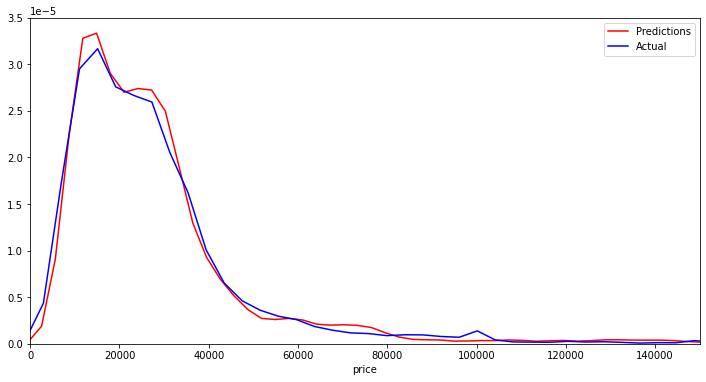

In [1370]:
plt.figure(figsize=(12,6))
plt.xlim(0, 150000)
sns.distplot((test_pred), label = 'Predictions', hist = False, color = 'r')
sns.distplot((y_test), label='Actual', hist = False, color = 'b')
plt.legend()
plt.show()

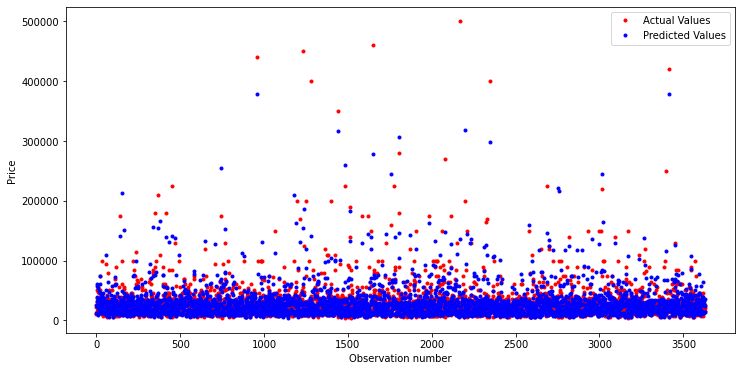

In [1371]:
plt.figure(figsize=(12,6))
plt.plot((y_test.to_list()), 'r.', label = 'Actual Values')
plt.plot((test_pred), 'b.', label = 'Predicted Values')
plt.xlabel('Observation number')
plt.ylabel('Price')
plt.legend()
plt.show()

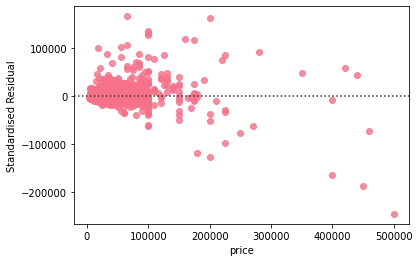

In [1372]:
sns.residplot(y_test, test_pred)
plt.ylabel('Standardised Residual')
plt.show()

#### Feature Importance

In [1373]:
cols = x_train_og.columns
imp = rf.feature_importances_
feat_imp = pd.DataFrame(data = imp, index=cols)

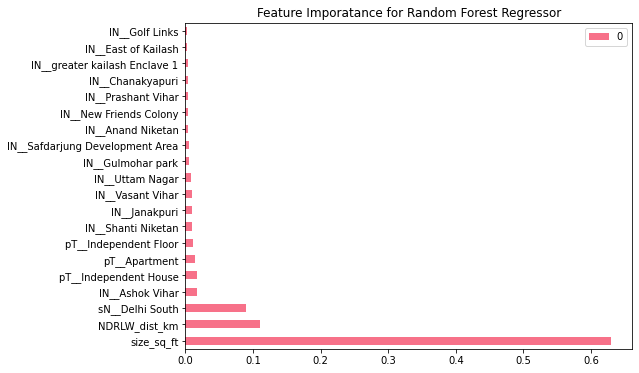

In [1374]:
feat_imp.sort_values(by = 0, ascending=False).head(20).plot(kind = 'barh',
                                                            figsize = (8,6)).set(title= 'Feature Imporatance for Random Forest Regressor')
plt.show()

### XGBoost Regressor 
1. Gives much worse training performance but generalises better. Test scores are better. 
2. Dropping suburb assuming info already in locality name gives much better performance and the importance is no longer dominated by the size variable. Interesting results, don't know which approach is better. 

In [950]:
from xgboost import XGBRegressor

In [1375]:
model = XGBRegressor(n_estimators = 1000,learning_rate=0.5,max_depth=6, n_jobs = 4,
                     objective='reg:squarederror', eval_metric= 'mae')

In [1376]:
model.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=True)

[0]	validation_0-mae:15099.05566
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:8954.34277
[2]	validation_0-mae:7027.51660
[3]	validation_0-mae:6575.77783
[4]	validation_0-mae:6459.10840
[5]	validation_0-mae:6474.28418
[6]	validation_0-mae:6480.30859
[7]	validation_0-mae:6491.77295
[8]	validation_0-mae:6412.50293
[9]	validation_0-mae:6405.90869
[10]	validation_0-mae:6408.07861
[11]	validation_0-mae:6414.47217
[12]	validation_0-mae:6410.30566
[13]	validation_0-mae:6385.81250
[14]	validation_0-mae:6393.43701
[15]	validation_0-mae:6399.21484
[16]	validation_0-mae:6394.11914
[17]	validation_0-mae:6387.48535
[18]	validation_0-mae:6384.83252
[19]	validation_0-mae:6389.46533
[20]	validation_0-mae:6392.71777
[21]	validation_0-mae:6384.39893
[22]	validation_0-mae:6366.23877
[23]	validation_0-mae:6383.36768
[24]	validation_0-mae:6391.72656
[25]	validation_0-mae:6376.52686
[26]	validation_0-mae:6373.17236
[27]	validation_0-mae:6366.66113
Stopping. Best iterati

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.5, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [959]:
# Takes a long time
get_train_metrics(model, x_train, x_test, y_train, y_test)

Training Metrics:
R2 : 0.6394255123096133, stdev 0.07271971843560512
MAE : -7134.871040112039, stdev 252.95827256671114
MSE : -366522807.2036116, stdev 55764062.37725556


In [1170]:
get_test_metrics(model, x_train, x_test, y_train, y_test)

KeyboardInterrupt: 

In [1379]:
test_pred = model.predict(x_test)

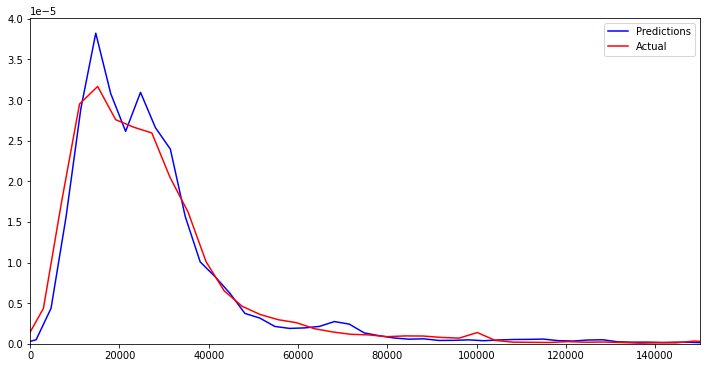

In [1380]:
plt.figure(figsize=(12,6))
plt.xlim(0, 150000)
sns.distplot((test_pred), label = 'Predictions', hist = False, color = 'b')
sns.distplot((y_test.to_list()), label='Actual', hist = False, color = 'r')
plt.legend()
plt.show()

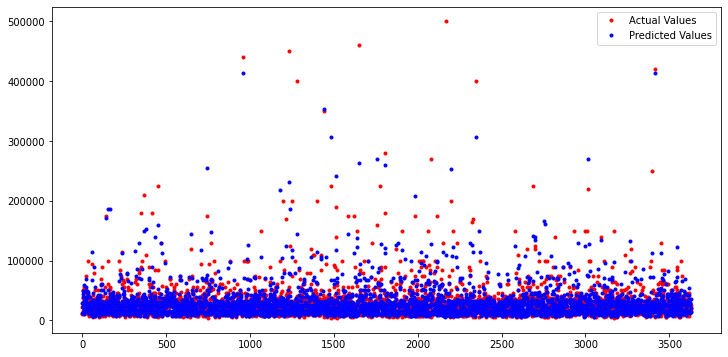

In [1381]:
plt.figure(figsize=(12,6))
plt.plot((y_test.to_list()), 'r.', label = 'Actual Values')
plt.plot((test_pred), 'b.', label = 'Predicted Values')
plt.legend()
plt.show()

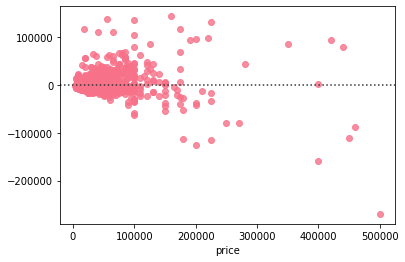

In [1382]:
sns.residplot(y_test, test_pred)
plt.show()

#### Feature Importance

In [1383]:
cols = data.drop(drop_cols, axis = 1).columns
imp = model.feature_importances_
feat_imp = pd.DataFrame(data = imp, index=cols)

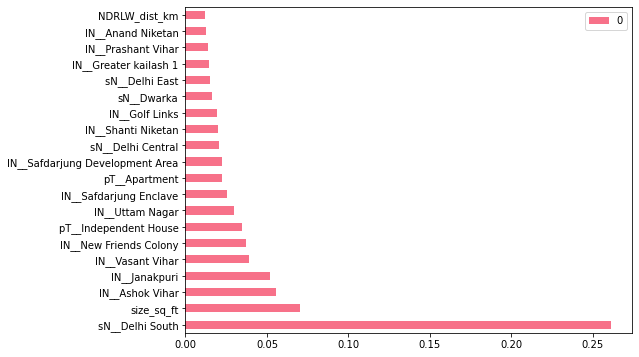

In [1384]:
feat_imp.sort_values(by = 0, ascending=False).head(20).plot(kind = 'barh', figsize = (8,6))

## Making Predictions
Inputs Required
1. size_sq_ft - int
2. NDRLW_dist_km - float (geodisc distance, how to get this ?)
3. suburb - object from choices. from dropdown list - possible to get weird combinations different suburb and locality.
4. Locality name - object from choices. from dropdown list - possible to get weird combinations different suburb and locality.
5. Input bedroom but no change in model output. (would seem weird)

In [1501]:
# Create a new DF with same columns as training data. 

predict = pd.DataFrame().reindex_like(final_feats[:1])
predict.fillna(0, inplace=True)

In [1502]:
# Inserting Features for predictions (1200 sq.feet Apartment in Dwarka sector 4, enter co-ordinates,
predict['size_sq_ft'] = 1750

In [1503]:
# propert type
pt = input("Input the Property Type")
predict['pT__' + pt] = 1

Input the Property TypeApartment


In [1504]:
# locality name 
ln = input("Input the Locality Name")
predict['lN__' + ln] = 1

Input the Locality NameSector 4 Dwarka


In [1505]:
# calc distance to NDLS RLW station)
My_house = 28.602238, 77.053812
Akhils_place = 28.560871, 77.190473
NDLS_railway = (28.6417, 77.2207)
test = 28.602354, 77.048932
from geopy.distance import geodesic

dist_ndls = geodesic(str(test[0]) + ',' + str(test[1]), str(28.6417) + ',' + str(77.2207)).km   

In [1506]:
predict['NDRLW_dist_km'] = dist_ndls

In [1507]:
# The suburb filed in addition to locality is problematic

#predict['sN__Delhi South'] = 1
predict['sN__Dwarka'] = 1

In [1050]:
# Input needs to be scaled before being passed to model, this is why a pipeline is useful.

In [1508]:
rf.predict(scale.transform(predict))

array([29250.])

In [1509]:
model.predict(scale.transform(predict))

array([30648.902], dtype=float32)

In [1052]:
predict.columns.to_list()

['size_sq_ft',
 'NDRLW_dist_km',
 'sN__Delhi Central',
 'sN__Delhi East',
 'sN__Delhi South',
 'sN__Dwarka',
 'sN__North Delhi',
 'sN__Rohini',
 'sN__West Delhi',
 'pT__Apartment',
 'pT__Independent Floor',
 'pT__Independent House',
 'pT__Villa',
 'lN__AGCR Enclave',
 'lN__Adchini',
 'lN__Alaknanda',
 'lN__Anand Niketan',
 'lN__Anand Parbat',
 'lN__Anand Vihar',
 'lN__Ashok Nagar',
 'lN__Ashok Vihar',
 'lN__Azadpur',
 'lN__Bali Nagar',
 'lN__Baljeet Nagar',
 'lN__Bhagwati Garden Extension',
 'lN__Bindapur',
 'lN__Block F',
 'lN__Burari',
 'lN__CA Apartments',
 'lN__Chanakyapuri',
 'lN__Chandra Park',
 'lN__Chattarpur',
 'lN__Civil Lines',
 'lN__Connaught Place',
 'lN__DWARKA SECTOR 9',
 'lN__Dabri',
 'lN__Defence Colony',
 'lN__Delhi',
 'lN__Dera Mandi',
 'lN__Derawal Nagar',
 'lN__Dhul Siras',
 'lN__Dilshad Garden',
 'lN__Dr Mukherji Nagar',
 'lN__Dwarka Mor',
 'lN__Dwarka More Mohan Garden',
 'lN__Dwarka New Delhi 110075',
 'lN__Dwarka Phase 2',
 'lN__Dwarka Sector 15',
 'lN__Dwarka 